In [3]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
from sklearn.ensemble import RandomForestClassifier


warnings.filterwarnings("ignore")

In [ ]:
# Current script folder
path = os.getcwd()
base_dir = path.split("da_case_studies")[0]

# Set the location of your data directory
data_dir = base_dir + "da_data_repo"

# location folders
data_in = os.path.join(data_dir, "bisnode-firms/clean/")
data_out = os.path.join(data_dir, "bisnode-firms/")
output = os.path.join(data_out, "output/")
func = os.path.join(base_dir, "da_case_studies/ch00-tech-prep/")
sys.path.append(func)

## Import data

In [120]:
# !!! make sure you have run ch17-firm-exit-data-prep.ipynb before
data_import = pd.read_csv(data_out + "bisnode_firms_clean.csv")

In [121]:
data = data_import.copy()

In [125]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
count,113829.000000,1.138290e+05,1.138290e+05,1.138290e+05,1.138290e+05,1.138250e+05,1.138250e+05,1.138240e+05,1.138290e+05,1.138290e+05,...,113829.000000,113829.000000,113829.000000,113829.000000,113829.000000,1.138290e+05,113829.000000,113829.000000,113829.000000,113829.000000
mean,2012.560297,1.536026e+11,2.127103e+04,2.320420e+05,1.845557e+05,1.396754e+03,3.849341e+03,2.457023e+03,2.594767e+05,2.177122e+04,...,0.004841,0.144805,0.249778,1.014747,0.176967,1.171803e+01,0.037574,0.023500,-0.008293,0.288177
std,1.696856,1.379119e+11,2.373055e+05,1.897016e+06,1.868143e+06,5.595210e+04,2.309933e+05,2.289301e+05,2.825445e+06,4.624466e+05,...,0.069406,0.351906,0.432886,4.197761,0.381643,1.019002e+01,0.190164,0.151486,0.536759,0.601358
min,2010.000000,1.001034e+06,-5.780000e+04,0.000000e+00,-8.759259e+03,-1.335852e+05,-2.550000e+04,-5.514540e+06,0.000000e+00,-2.320988e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.087363e-09,0.000000,0.000000,-1.500000,0.000000
25%,2011.000000,2.877840e+10,1.777778e+02,3.833333e+03,3.722222e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.962963e+02,-5.125926e+03,...,0.000000,0.000000,0.000000,0.152778,0.000000,3.771318e+00,0.000000,0.000000,-0.150288,0.001245
50%,2013.000000,1.148665e+11,1.066667e+03,1.305556e+04,1.528519e+04,0.000000e+00,0.000000e+00,0.000000e+00,5.711111e+03,5.222222e+02,...,0.000000,0.000000,0.000000,0.348485,0.000000,9.234980e+00,0.000000,0.000000,0.000000,0.027430
75%,2014.000000,2.576837e+11,4.722222e+03,4.639259e+04,5.206296e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.729259e+04,5.711111e+03,...,0.000000,0.000000,0.000000,1.033012,0.000000,1.671651e+01,0.000000,0.000000,0.178348,0.190346
max,2015.000000,4.641050e+11,2.799496e+07,1.411015e+08,3.264051e+08,1.391812e+07,7.233078e+07,7.233078e+07,4.513921e+08,7.921782e+07,...,1.000000,1.000000,1.000000,182.260422,1.000000,4.771708e+01,1.000000,1.000000,1.500000,2.250000


## Define helper functions

In [130]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=np.arange(0, 1.1, 0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            color="black",
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=np.arange(0, 1.1, 0.1))
        + scale_x_continuous(breaks=np.arange(0, 1.1, 0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot


In [131]:
# Extract sales for 2012 and 2014 separately
sales_2012 = data[data["year"] == 2012][["comp_id", "sales"]].rename(columns={"sales": "sales_2012"})
sales_2014 = data[data["year"] == 2014][["comp_id", "sales"]].rename(columns={"sales": "sales_2014"})

# Merge both datasets on "comp_id"
data_growth = sales_2014.merge(sales_2012, on="comp_id", how="left")

# Compute annualized growth rate (CAGR formula)
data_growth["annual_growth_2y"] = ((data_growth["sales_2014"] / data_growth["sales_2012"]) ** (1/2)) - 1

# Define high-growth firms (growth > 30%)
data_growth["high_growth"] = (data_growth["annual_growth_2y"] > 0.3).astype(int)

# Merge high-growth label back to the full dataset (assign to all years per firm)
data = data.merge(data_growth[["comp_id", "annual_growth_2y", "high_growth"]], on="comp_id", how="left")

# Fill NaN with 0 (for firms that were not classified as high growth)
data["high_growth"] = data["high_growth"].fillna(0).astype(int)

# Print to check
print(data[["comp_id", "year", "sales", "annual_growth_2y", "high_growth"]].head(10))


     comp_id  year         sales  annual_growth_2y  high_growth
0  1001034.0  2010  9.929630e+03               NaN            0
1  1002029.0  2010  8.437741e+05         -0.563289            0
2  1003200.0  2010  1.379259e+04               NaN            0
3  1004012.0  2010  2.533333e+03               NaN            0
4  1007261.0  2010  2.188889e+03               NaN            0
5  1011889.0  2010  3.414592e+05          0.044210            0
6  1014183.0  2010  1.073815e+05         -0.117423            0
7  1022796.0  2010  2.915555e+04          0.336936            1
8  1046213.0  2010  3.734748e+06          0.248975            0
9  1056952.0  2010  7.872593e+04               NaN            0


In [139]:
data["annual_growth_2y"].describe()

count    80172.000000
mean         0.173394
std          0.992457
min         -0.957643
25%         -0.090282
50%          0.056141
75%          0.228989
max         70.394471
Name: annual_growth_2y, dtype: float64

We filter out all observations with growth rates below -90% and above 300% as these are seen as outliers

In [143]:
data = data[
    (data["annual_growth_2y"] >= -0.9) &
    (data["annual_growth_2y"] <= 3)
]

In [144]:
data["annual_growth_2y"].describe()

count    79225.000000
mean         0.110633
std          0.434697
min         -0.898106
25%         -0.091889
50%          0.053832
75%          0.219586
max          2.990322
Name: annual_growth_2y, dtype: float64

## Model building

### Define variable sets 

In [147]:
firm_basics = ["age", "age2", "new", "profit_loss_year", "C(ind2_cat)", "total_assets_bs"]

In [148]:
balance_sheet = [
    "curr_assets",
    "curr_liab",
    "fixed_assets",
    "intang_assets",
    "inventories",
    "liq_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
    "curr_assets_bs",
    "curr_liab_bs",
    "fixed_assets_bs",
    "intang_assets_bs",
    "liq_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "tang_assets_bs",
    "balsheet_flag",
    "balsheet_length",
    "balsheet_notfullyear"
]

In [149]:
income_expense = [
    "amort",
    "inc_bef_tax",
    "profit_loss_year",
    "material_exp",
    "personnel_exp",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss"
]

In [151]:
hr = [
    "ceo_age",
    "ceo_young",
    "C(gender_m)",
    "C(gender)",
    "C(origin)",
    "foreign_management",
    "inoffice_days",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "flag_miss_labor_avg",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
]   

In [152]:
location = ["C(urban_m)", "C(region_m)"]

In [154]:
data["labor_avg_mod2"] = data["labor_avg_mod"] ** 2

In [155]:
poly = [
    "labor_avg_mod2",
    "share_eq_bs_quad"
]    

In [156]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*labor_avg_mod",
]

interactions2 = [
    "ceo_age*C(female)",
    "ceo_age*labor_avg_mod",
]

interactions3 = [
    "age*total_assets_bs",
    "age*ceo_age",
    "age*C(ind2_cat)",
    "age*labor_avg_mod",
    "age*share_eq_bs"
]

## Model setups

1. Simple logit models

In [159]:
M1 = (firm_basics)
M2 = (firm_basics + balance_sheet)
M3 = (firm_basics + balance_sheet + income_expense + hr + location)
M4 = (firm_basics + balance_sheet + income_expense + hr + location + poly + interactions1)
M5 = (firm_basics + balance_sheet + income_expense + hr + location + poly + interactions1 + interactions2 + interactions3)

2. logit+LASSO

In [161]:
logit_lasso_vars = (
    firm_basics + balance_sheet + income_expense + hr + location + poly + interactions1 + interactions2 + interactions3
)

3. CART and RF (no interactions, no modified features)

In [163]:
rfvars = (firm_basics + balance_sheet + income_expense + hr + location)

## 0. Separate train and holdout data

In [177]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [181]:
print("Total")
print(data["high_growth"].value_counts(normalize=True))
print("Train")
print(data_train["high_growth"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["high_growth"].value_counts(normalize=True))


Total
high_growth
0    0.812749
1    0.187251
Name: proportion, dtype: float64
Train
high_growth
0    0.812259
1    0.187741
Name: proportion, dtype: float64
Holdout
high_growth
0    0.814705
1    0.185295
Name: proportion, dtype: float64


## 1. Predict probabilities with logit and Lasso with CV

Specify 5 fold cross-validation method

In [189]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### a) cross validate logit models

Set up X-vars

In [192]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [194]:
C_value_logit = [1e20]

In [195]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "high_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [196]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.386917,0.384960,0.382337,0.381716,0.382256
1,0.380790,0.379745,0.382701,0.381555,0.382405
2,0.387790,0.387244,0.385749,0.385126,0.385099
3,0.385425,0.386156,0.384724,0.384776,0.385078
4,0.386184,0.384880,0.385151,0.384497,0.384662


### b) Logit + LASSO

In [198]:
model_equation = "high_growth~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

Normalise X vars for Lasso

In [200]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

Set regularization parameters

In [202]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

Initialize and fit Logit Lasso

In [204]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

See CV-fold RMSE-s (negative brier score)

In [206]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000197,0.403105
1,0.046416,0.000425,0.391110
2,0.021544,0.000915,0.385963
3,0.010000,0.001972,0.383620
4,0.004642,0.004249,0.382285
5,0.002154,0.009155,0.381681
6,0.001000,0.019724,0.381018
7,0.000464,0.042493,0.380688
8,0.000215,0.091549,0.380543
9,0.000100,0.197236,0.380514


Save best lambda's index for later use

In [208]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

Extract CV test RMSE for the Lasso with best lambda

In [210]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

In [211]:
CV_RMSE_folds

{'M1': array([0.3869166 , 0.3807903 , 0.38779048, 0.3854248 , 0.38618408]),
 'M2': array([0.38495964, 0.3797454 , 0.38724374, 0.3861563 , 0.38488019]),
 'M3': array([0.3823365 , 0.38270074, 0.38574926, 0.38472413, 0.38515058]),
 'M4': array([0.38171619, 0.38155509, 0.38512586, 0.38477622, 0.38449684]),
 'M5': array([0.38225612, 0.3824053 , 0.3850986 , 0.38507764, 0.3846625 ]),
 'LASSO': array([0.37843827, 0.37847072, 0.38218468, 0.38191243, 0.38154747])}

## 2.  AUC, Calibration Curve, Confusion Matrix, ROC

0. Calculate AUC for folds


First, for logits

In [216]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "high_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

For Lasso

In [218]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

Put a summary frame together

In [220]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [221]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

103

In [222]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

103

In [223]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,13,0.385421,0.626675
M2,33,0.384597,0.625130
M3,60,0.384132,0.634248
M4,90,0.383534,0.641523
M5,117,0.383900,0.636605
LASSO,103,0.380511,0.660882


### Take best model and estimate RMSE on holdout  

M4, M5 and LASSO are close - But M4 seems to be the simplest out of them, so we will take M4

In [229]:
best_logit = logit_models["M4"]
model_equation = "high_growth~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

Best logit holdout RMSE


In [232]:
print(len(X_holdout), len(data_holdout))


15845 15845


In [233]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["high_growth"]), 3)

0.38

### Confusion table with different tresholds

high_growth: the threshold 0.5 is used to convert probabilities to binary classes

In [249]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (no high_growth): ", counts[0])
print(values[1], " (high_growth): ", counts[1])

0.0  (no high_growth):  15833
1.0  (high_growth):  12


Confusion matrix: summarize different type of errors and successfully predicted cases

positive = "yes": explicitly specify the positive case

In [252]:
cm_object1 = confusion_matrix(
    data_holdout["high_growth"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul no high_growth", "Actual high_growth"],
    columns=["Predicted no high_growth", "Predicted high_growth"],
)
cm1

,Predicted no high_growth,Predicted high_growth
Actul no high_growth,12905,4
Actual high_growth,2928,8


In [254]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["high_growth"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul no high_growth", "Actual high_growth"],
    columns=["Predicted no high_growth", "Predicted high_growth"],
)
cm1b

,Predicted no high_growth,Predicted high_growth
Actul no high_growth,12905,4
Actual high_growth,2928,8


A sensible choice: mean of predicted probabilities

In [256]:
mean_predicted_high_growth_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_high_growth_prob, 3)

0.188

In [ ]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_high_growth_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["high_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual no high_growth", "Actual high_growth"],
    columns=["Predicted no high_growth", "Predicted high_growth"],
)
cm2

### Visualize ROC (with thresholds in steps) on holdout

What if we want to compare multiple thresholds?

First, discrete ROC (with thresholds in steps) on holdout

In [259]:
data_holdout["best_logit_pred_proba"].describe()


count    1.584500e+04
mean     1.880955e-01
std      8.232285e-02
min      5.211202e-07
25%      1.251990e-01
50%      1.743482e-01
75%      2.456335e-01
max      8.944022e-01
Name: best_logit_pred_proba, dtype: float64

In [260]:
thresholds = np.arange(0.05, 1.01, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["high_growth"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [261]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

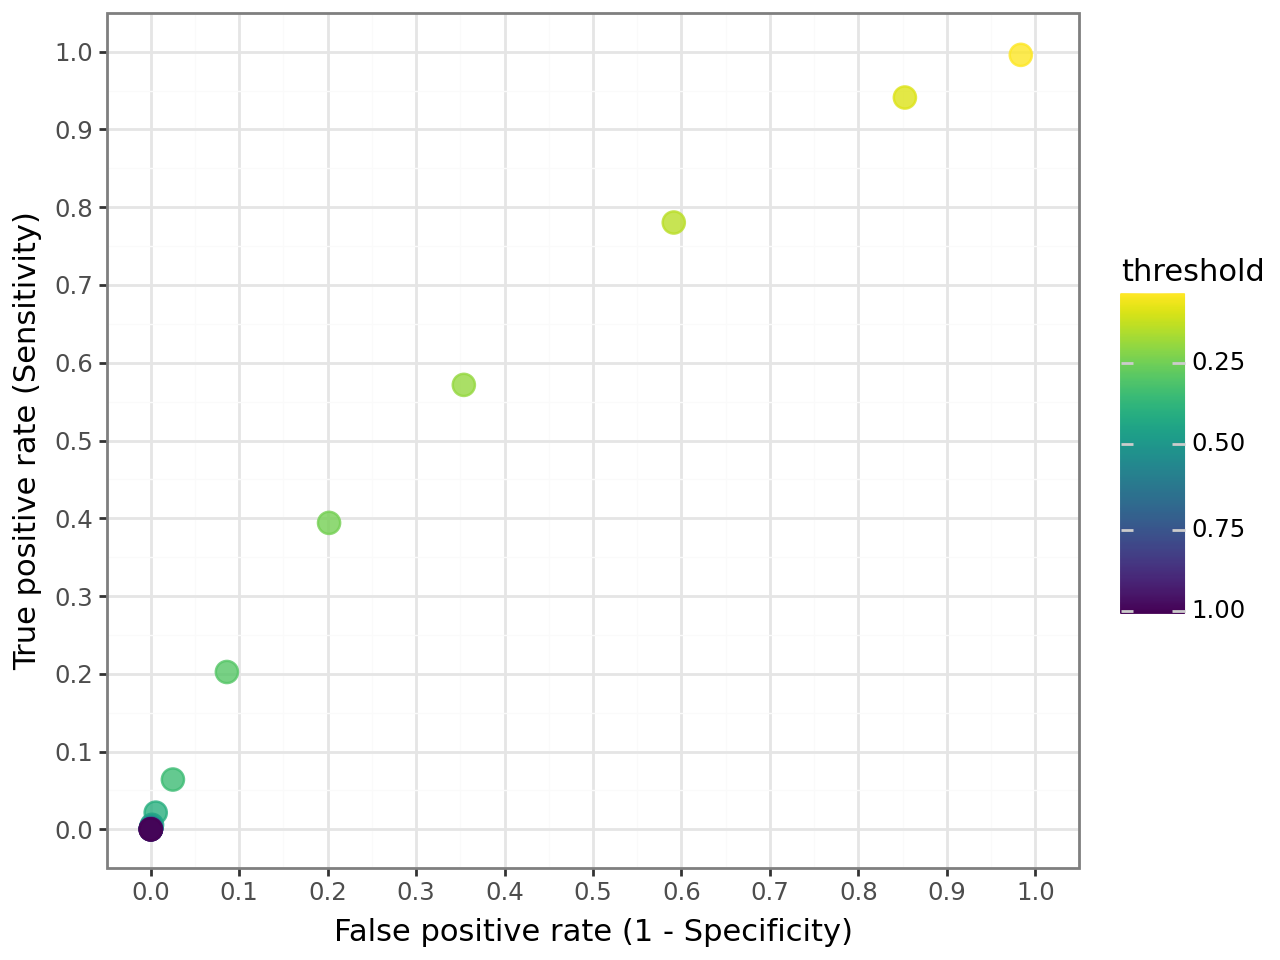

In [262]:
(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)

Continuous ROC on holdout with best model

In [271]:
color = "black"

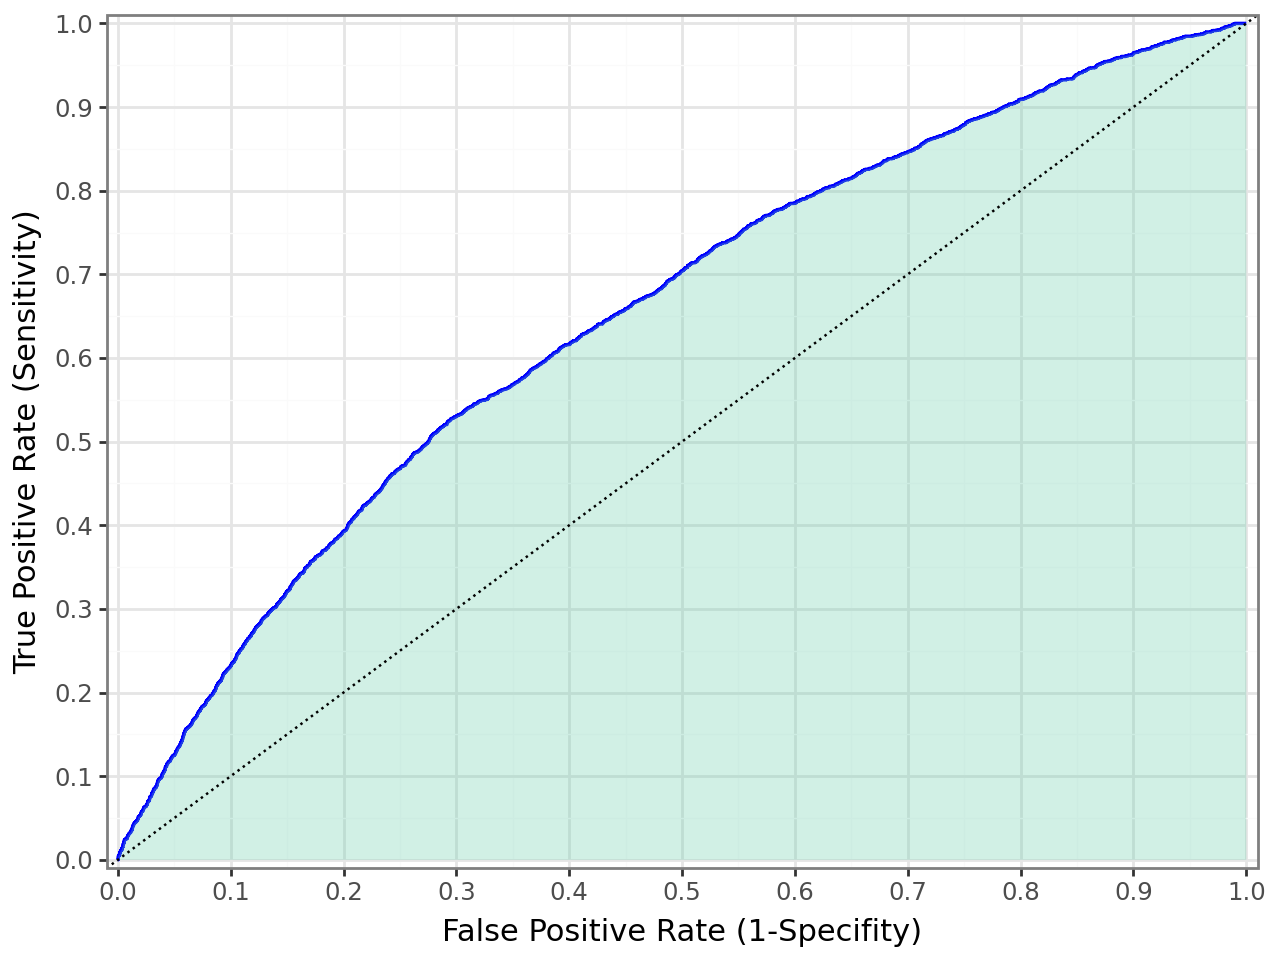

In [272]:
create_roc_plot(data_holdout["high_growth"], data_holdout["best_logit_pred_proba"])

## 3. We have a loss function

Introduce loss function

Relative cost of of a false negative classification (as compared with a false positive classification)


In [274]:
FP = 1
FN = 10
cost = FN / FP

The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))


In [276]:
prevelance = y_train.sum() / len(y_train)

Draw ROC Curve and find optimal threshold with loss function 

The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

Iterate through:
 1. models
 2. Folds

In [278]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("high_growth ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["high_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [279]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()


In [280]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.034583,2.613728e-02,0.811824,0.805996
1,M2,0.026139,2.979983e-03,0.811619,0.805917
2,M3,0.000042,1.215931e-07,0.812169,0.806706
3,M4,0.000268,5.630343e-07,0.812105,0.806706
4,M5,0.000231,1.733103e-06,0.812169,0.806706
5,LASSO,0.000181,3.042944e-04,0.812011,0.806075


Create loss plot based on Fold5 in CV 

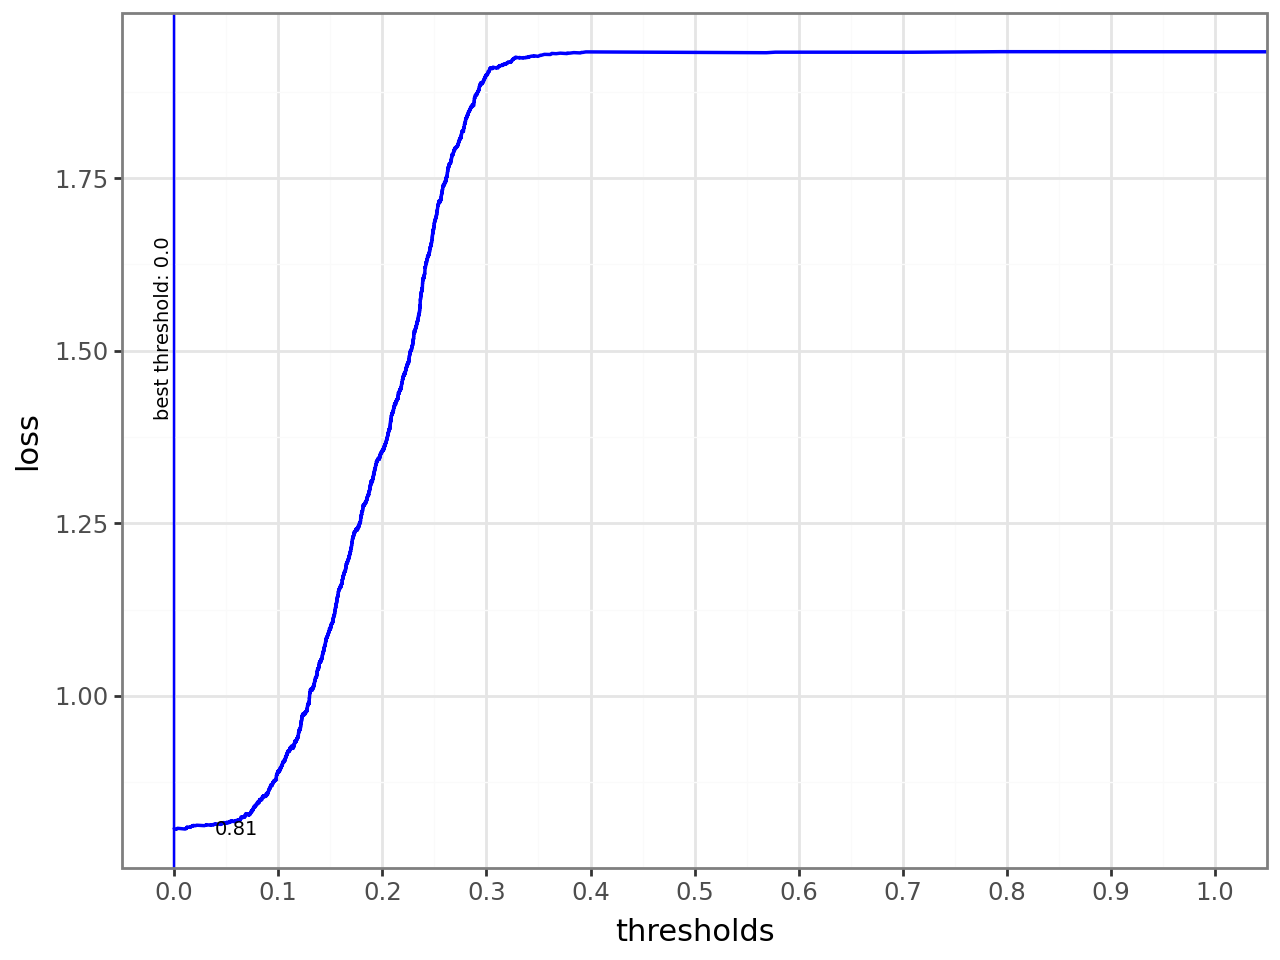

In [283]:
model_to_plot = "M4"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

In [284]:

print("Min probability:", np.min(data_holdout["best_logit_pred_proba"]))
print("Max probability:", np.max(data_holdout["best_logit_pred_proba"]))
print("Mean probability:", np.mean(data_holdout["best_logit_pred_proba"]))


Min probability: 5.211201890323784e-07
Max probability: 0.8944021994465812
Mean probability: 0.1880954921243785


Create roc plot plot based on Fold5 in CV

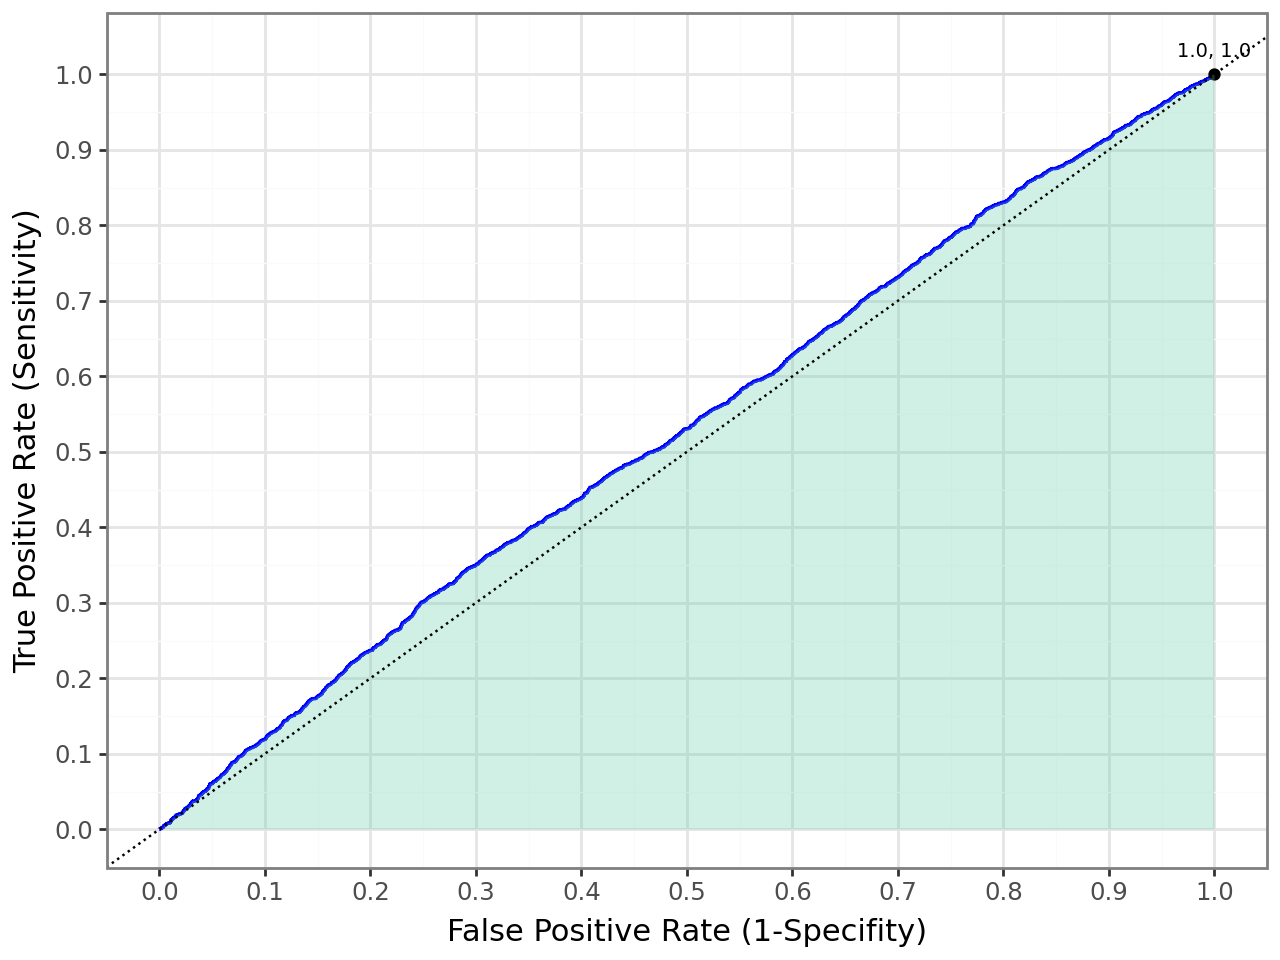

In [286]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)


Let's see our chosen model, M4's holdout expected loss

In [291]:
best_logit_optimal_treshold = best_thresholds_cv["M3"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["high_growth"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["high_growth"])
round(expected_loss_holdout, 3)

0.814

CM on holdout

In [293]:
cm_object3 = confusion_matrix(data_holdout["high_growth"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actual no high_growth", "Actual high_growth"],
    columns=["Predicted no high_growth", "Predicted high_growth"],
)
cm3

,Predicted no high_growth,Predicted high_growth
Actual no high_growth,7,12902
Actual high_growth,0,2936


# PREDICTION WITH RANDOM FOREST

In [295]:
y_train, rfvars_train = patsy.dmatrices("high_growth~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("high_growth~" + "+".join(rfvars), data_holdout)

## Probability forest

Split by gini, ratio of 1's in each tree, average over trees

Unfortunately, due to issues with computing power we had to scale down this model.

In [324]:
grid = {
    "max_features": [5, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [327]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=100, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid, 
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [328]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

Create CV summary table

In [331]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.837613,0.347599
1,5,16,0.826591,0.350929
2,7,11,0.839858,0.345756
3,7,16,0.828739,0.349144


Obtain optimal parameter values

In [333]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 11}

Get average (ie over the folds) RMSE and AUC

In [335]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [336]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,13.0,0.385421,0.626675
M2,33.0,0.384597,0.625130
M3,60.0,0.384132,0.634248
M4,90.0,0.383534,0.641523
M5,117.0,0.383900,0.636605
LASSO,103.0,0.380511,0.660882
RF,n.a.,0.345756,0.839858


Extract fold level RMSE and AUC

In [338]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

Take a look at foldwise RMSE and AUC

In [340]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.386917,0.384960,0.382337,0.381716,0.382256,0.378438,0.343914
1,0.380790,0.379745,0.382701,0.381555,0.382405,0.378471,0.344266
2,0.387790,0.387244,0.385749,0.385126,0.385099,0.382185,0.347271
3,0.385425,0.386156,0.384724,0.384776,0.385078,0.381912,0.346104
4,0.386184,0.384880,0.385151,0.384497,0.384662,0.381547,0.347210


In [341]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.617930,0.618882,0.634679,0.643249,0.635298,0.663277,0.844985
1,0.630564,0.635820,0.631174,0.641943,0.632672,0.662817,0.839429
2,0.629978,0.627959,0.640376,0.645711,0.647003,0.664731,0.841099
3,0.628895,0.618074,0.628628,0.634483,0.630148,0.654196,0.836859
4,0.626008,0.624914,0.636385,0.642232,0.637904,0.659390,0.836919


Now use loss function and search for best thresholds and expected loss over folds 

In [343]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["high_growth"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["high_growth"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [344]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)


In [345]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.346,0.84,0.052,0.059,0.812,0.806


Create plots based on Fold5 in CV 

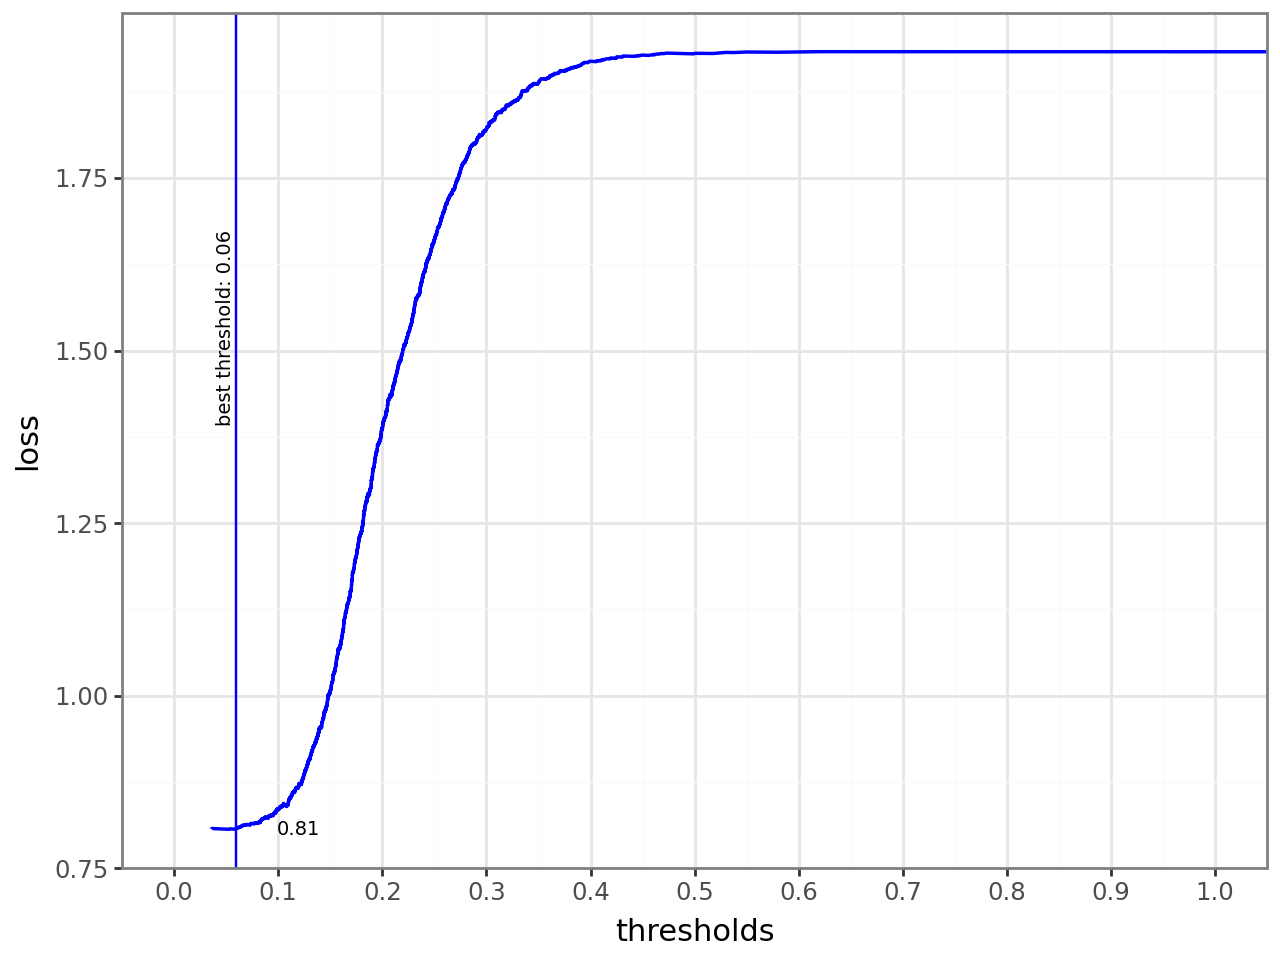

In [347]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

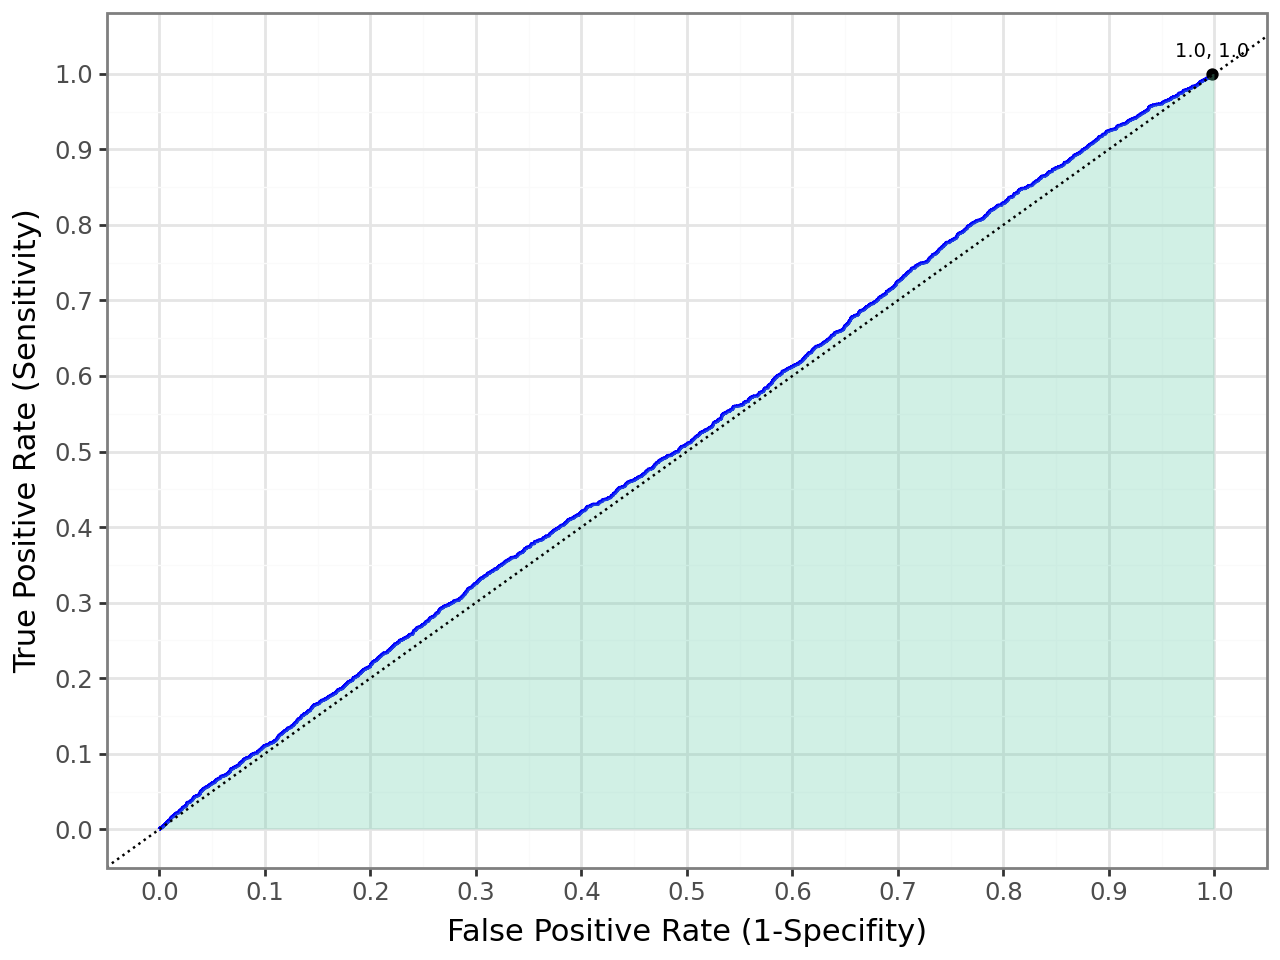

In [348]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

Take model to holdout and estimate RMSE, AUC and expected loss 

In [350]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


0.339

ROC AUC  on holdout

In [352]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


0.857

 Get expected loss on holdout

In [354]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


0.748

## Our own model

XGBoost

In [358]:
# Train XGBoost on fold training set
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",  # Outputs probabilities
    eval_metric="logloss",
    use_label_encoder=False,
    learning_rate=0.1,
    n_estimators=500,  # Adjusted to run faster
    max_depth=3,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42
)

xgb_model.fit(X_fold_train, y_fold_train)  # Training on fold-specific data

# Predict probabilities on validation fold
y_pred_xgb = xgb_model.predict_proba(X_fold)[:, 1]

# Evaluate performance using AUC-ROC
auc_xgb = roc_auc_score(y_fold, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_fold, y_pred_xgb))

print("XGBoost AUC-ROC Score for Fold:", auc_xgb)
print("XGBoost RMSE for Fold:", rmse_xgb)

XGBoost AUC-ROC Score for Fold: 0.5252986178334415
XGBoost RMSE for Fold: 0.39593028290883553


In [380]:
# Initialize lists to store results across folds
best_thresholds_xgb = []
expected_loss_xgb = []

# Define cost parameters (if applicable)
FP = 1  # Cost of false positives (adjust based on your use case)
FN = 1  # Cost of false negatives (adjust based on your use case)
prevalence = np.mean(y_fold)  # Adjust based on actual prevalence in the dataset

# Compute threshold and expected loss
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, y_pred_xgb)
optimal_threshold = sorted(
    zip(
        np.abs(true_pos_rate + (1 - prevalence) / (FP * prevalence) * (1 - false_pos_rate)), 
        thresholds
    ),
    key=lambda x: x[0], reverse=True
)[0][1]

best_thresholds_xgb.append(optimal_threshold)

# Convert probabilities to binary predictions
threshold_prediction = np.where(y_pred_xgb < optimal_threshold, 0, 1)

# Compute confusion matrix elements
tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0, 1]).ravel()

# Compute expected loss
curr_exp_loss = 1 - (fp * FP + fn * FN) / len(y_fold)
expected_loss_xgb.append(curr_exp_loss)


In [382]:
expected_loss_cv["XGB"] = np.mean(expected_loss_xgb)  # Store average expected loss
best_thresholds_cv["XGB"] = np.mean(best_thresholds_xgb)  # Store average threshold
CV_RMSE_folds["XGB"] = rmse_xgb  # RMSE from earlier
CV_AUC_folds["XGB"] = auc_xgb  # AUC from earlier


In [384]:
summary.loc["XGB"] = [
    "n.a.",  # Number of Coefficients (not applicable for tree models)
    CV_RMSE_folds["XGB"],  # RMSE for XGBoost
    CV_AUC_folds["XGB"],   # AUC for XGBoost
    best_thresholds_cv["XGB"],  # Best threshold for XGBoost
    expected_loss_cv["XGB"]  # Expected loss for XGBoost
]

## Final results

In [387]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [389]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,13.0,0.385421,0.626675,0.034583,0.811824
M2,33.0,0.384597,0.625130,0.026139,0.811619
M3,60.0,0.384132,0.634248,0.000042,0.812169
M4,90.0,0.383534,0.641523,0.000268,0.812105
M5,117.0,0.383900,0.636605,0.000231,0.812169
LASSO,103.0,0.380511,0.660882,0.000181,0.812011
RF,n.a.,0.345756,0.839858,0.051900,0.812027
XGB,n.a.,0.395930,0.525299,0.533651,0.806864


# Task 2

In [375]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

# Step 1: Categorize Industries into Manufacturing and Services
manufacturing_codes = [27, 28, 29, 30, 32, 33, 35]  # Manufacturing industry codes
services_codes = [55, 56, 60]  # Services industry codes (repair, accommodation, food)

# Assign industry type: 0 = Manufacturing, 1 = Services
data_train["industry_type"] = data_train["ind2_cat"].apply(
    lambda x: 0 if x in manufacturing_codes else (1 if x in services_codes else np.nan)
)

# Filter data into Manufacturing and Services
manufacturing_data = data_train[data_train["industry_type"] == 0]
services_data = data_train[data_train["industry_type"] == 1]

# Step 2: Define a Single Loss Function (Log Loss for probability predictions)
def compute_loss(y_true, y_pred_probs):
    return log_loss(y_true, y_pred_probs)

# Step 3: Train an XGBoost Model Separately for Each Group
def train_xgboost(X, y):
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        enable_categorical=True,  # Allow categorical columns
        learning_rate=0.1,
        n_estimators=50,  # Adjusted for efficiency
        max_depth=3,
        colsample_bytree=0.8,
        subsample=0.8,
        random_state=42
    )
    model.fit(X, y)
    return model


# Prepare data: Exclude target variable and industry column
X_manuf = manufacturing_data.drop(columns=["high_growth", "industry_type", "ind2_cat"])
y_manuf = manufacturing_data["high_growth"]

X_service = services_data.drop(columns=["high_growth", "industry_type", "ind2_cat"])
y_service = services_data["high_growth"]

# 🔹 Convert categorical variables to numeric (one-hot encoding)
X_manuf = pd.get_dummies(X_manuf, drop_first=True)
X_service = pd.get_dummies(X_service, drop_first=True)

# Train separate models for Manufacturing and Services
xgb_model_manuf = train_xgboost(X_manuf, y_manuf)
xgb_model_service = train_xgboost(X_service, y_service)

# Step 4: Evaluate and Compare Performance
# Get probability predictions
y_pred_manuf = xgb_model_manuf.predict_proba(X_manuf)[:, 1]
y_pred_service = xgb_model_service.predict_proba(X_service)[:, 1]

# Compute AUC and Loss for both models
auc_manuf = roc_auc_score(y_manuf, y_pred_manuf)
loss_manuf = compute_loss(y_manuf, y_pred_manuf)

auc_service = roc_auc_score(y_service, y_pred_service)
loss_service = compute_loss(y_service, y_pred_service)

# Create a summary table to compare performance
comparison_df = pd.DataFrame({
    "Industry": ["Manufacturing", "Services"],
    "AUC-ROC": [auc_manuf, auc_service],
    "Log Loss": [loss_manuf, loss_service]
})

# Display final results
print("\n=== Model Performance Comparison ===")
print(comparison_df)



=== Model Performance Comparison ===
        Industry  AUC-ROC  Log Loss
0  Manufacturing      1.0  0.008214
1       Services      1.0  0.010706
